<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
CUDA_CORE=0
MODEL_USED="facebook/nllb-200-distilled-600M"
# MODEL_USED="facebook/nllb-200-1.3B"
# MODEL_USED="facebook/nllb-200-3.3B"
MODEL_SAVE_PATH="models/nllb_wayuu_esp_sin_dict_600M"
LANGUAGE_ORIGIN_LABEL="spa_Latn"
LANGUAGE_TARGET_LABEL="way_Latn"
LANGUAGE_SIMILAR_LABEL="ayr_Latn" # Central Aymara
LANGUAGE_FILE="data/wayuu_sin_dict.csv"
LANGUAGE_FILE_ORIGIN_LABEL="esp"
LANGUAGE_FILE_TARGET_LABEL="way"
NORMALIZER_LANGUAGE="es"
!mkdir -p {MODEL_SAVE_PATH}

In [2]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [3]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

In [4]:
!pip install ipywidgets

In [5]:
!pip install scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split

<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [6]:
trans_df = pd.read_csv(LANGUAGE_FILE)
print(trans_df.shape)
print(trans_df.columns)

(1376, 2)
Index(['way', 'esp'], dtype='object')


In [7]:
df_train, df_devtest = train_test_split(trans_df, test_size=0.2, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=42)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1100 entries, 532 to 1126
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   way     1100 non-null   object
 1   esp     1100 non-null   object
dtypes: object(2)
memory usage: 25.8+ KB


In [9]:
df_train.head()

,way,esp
532,"Aa, oꞌuneena waya jooluꞌu eemüin tü aiküleekaa...","Si, ahora vamos a esa tienda de mantas."
243,Oꞌoojeerü,Yo me bañare
370,Shijimein,El pescado de ella
1216,Aneechi ma'in pia nükajee chi püchon mulo'ush...,Tú estarás bien por causa de tu hijo mayor; y/...
813,"A’lakajaashi Kamiirü (taya, nia, pia)","Camilo cocina (yo cocino , él cocina , tú coc..."


In [10]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 527 to 1114
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   way     138 non-null    object
 1   esp     138 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [11]:
df_dev.head()

,way,esp
527,"Cho'ujaale pümüin soo'omüin asalaa, peenajeech...","Si necesitas más carne, me llamas y te la llev..."
583,Shia neꞋe tanüiki jümüin .,Eso es todo lo que les digo.
893,¿Nnojotsü kasain ali in pünain? – majüshi laül...,¿No te duele nada? - decía el viejo.
265,¿Kasa paa Ꞌinraka?,¿Qué haces?
1201,Ojoiteena waya putuushi.,Nosotros enterraremos a tu abuelo.


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 818 to 693
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   way     138 non-null    object
 1   esp     138 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [13]:
df_test.head()

,way,esp
818,Püya’lajeeerü tü meruuna kalü,Tú comprarás el melón . (Específico)
528,Antüshii jia. ¿Kasa jüchajaaka?,"Bienvenidas, ¿Qué están buscando?"
1268,Jo´uuchonjaasü naa´in Ma´leiwa Ø mapünajüin re...,Se empequeñece el corazón de Dios si no sembra...
1055,Nuchuntuin sümüin Tareesa apünüin kasa.,Él le pidió tres cosas a Teresa.
622,Anü karalo'utakaa,Aquí está el libro


# 2. How well does the data fit into a NLLB tokenizer?

In [14]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [15]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)

In [16]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [17]:
smpl = df_train.sample(10000, random_state=42, replace=True)
smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_toks'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(tokenizer.tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_toks'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(tokenizer.tokenize)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_words'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(word_tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_words'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(word_tokenize)

In [18]:
smpl.sample(5)[[LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_toks']]

,esp,esp_words,esp_toks,way,way_words,way_toks
881,Nosotros nos dirigimos hacia donde está nuest...,"[Nosotros, nos, dirigimos, hacia, donde, está,...","[▁Nosotros, ▁nos, ▁dirig, imos, ▁hacia, ▁donde...",Chainjana waya eemüin chi watuushikai .,"[Chainjana, waya, eemüin, chi, watuushikai, .]","[▁Cha, in, jana, ▁waya, ▁eem, ü, in, ▁chi, ▁wa..."
960,"Porque él era muy diligente cazando, siempre s...","[Porque, él, era, muy, diligente, cazando, ,, ...","[▁Porque, ▁él, ▁era, ▁muy, ▁di, lig, ente, ▁ca...","Aka tütüin ma’in nia jünain olojoo, ale’ejapu’...","[Aka, tütüin, ma, ’, in, nia, jünain, olojoo, ...","[▁Aka, ▁t, üt, ü, in, ▁ma, ’, in, ▁nia, ▁j, ün..."
1128,"¿El maestro es viejo , o es joven?","[¿, El, maestro, es, viejo, ,, o, es, joven, ?]","[▁¿, El, ▁maestro, ▁es, ▁viejo, ▁,, ▁o, ▁es, ▁...","¿Laülaa chi ekirajüikai , jima'ai pa eera nia?","[¿, Laülaa, chi, ekirajüikai, ,, jima, ', ai, ...","[▁¿, La, ü, laa, ▁chi, ▁ek, ira, j, ü, ikai, ▁..."
614,Está enfermo,"[Está, enfermo]","[▁Está, ▁enfer, mo]",Ayuuishi,[Ayuuishi],"[▁Ay, uu, ishi]"
540,"Prefiero las blancas, son más bonitas.","[Prefiero, las, blancas, ,, son, más, bonitas, .]","[▁Pre, fi, ero, ▁las, ▁blan, cas, ,, ▁son, ▁má...","Tacheküin tü kasutatk aa, anache ꞌechonsü.","[Tacheküin, tü, kasutatk, aa, ,, anache, ꞌecho...","[▁Tach, ek, ü, in, ▁tü, ▁kas, utat, k, ▁aa, ,,..."


In [19]:
stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()
stats

/tmp/ipykernel_263650/105503015.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()


,esp_toks,way_toks,esp_words,way_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,13.386800,21.855300,10.677900,11.364700
std,19.365885,29.676004,15.125179,15.416513
min,1.000000,1.000000,1.000000,1.000000
25%,7.000000,10.000000,6.000000,5.000000
50%,11.000000,17.000000,9.000000,9.000000
75%,15.000000,26.000000,12.000000,13.000000
max,279.000000,386.000000,218.000000,205.000000


In [20]:
print(stats[LANGUAGE_FILE_ORIGIN_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_ORIGIN_LABEL + "_words"]['mean'])
print(stats[LANGUAGE_FILE_TARGET_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_TARGET_LABEL + "_words"]['mean'])

1.253692205396192
1.9230863991130431


In [21]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for quechua? If this is too often, we need to fix it somehow</p>

In [22]:
texts_with_unk = [text for text in tqdm(trans_df[LANGUAGE_FILE_TARGET_LABEL]) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/1376 [00:00<?, ?it/s]

401


In [23]:
import random
s = random.sample(texts_with_unk, 5)
s

['¿Jala pünaashii paa’akana yaa ?',
 "Aa, tayaawatüin pia - müshija'a niakai jümüin  nu’wayuuse  paülü'üjee.",
 'Nnojotsü aku ’lajaain waa’in sü maa atijaa wayuunaiki.',
 'A’ttaainjatü püliikukolu wanee müin ja ’ata luwopukolu.',
 "Jaja'ttiamüin kashikalü pa’atapajeechi taya ma’aka kaso’urüle tantüin."]

In [24]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang=NORMALIZER_LANGUAGE)
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [25]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/401 [00:00<?, ?it/s]

0


<h1 id="3.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Expanding the vocabulary</h1>

In [26]:
from collections import Counter
all_texts = trans_df[LANGUAGE_FILE_TARGET_LABEL]
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common() 
    if v >= 3 and k not in ' '
])

  0%|          | 0/1376 [00:00<?, ?it/s]

In [27]:
all_texts_file = MODEL_SAVE_PATH + "/all_texts_file.csv"
trans_df[LANGUAGE_FILE_TARGET_LABEL].to_csv(all_texts_file, sep='|', index=False, header=False)

In [28]:
import sentencepiece as spm

SPM_PREFIX = MODEL_SAVE_PATH + '/spm_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=2**11,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: models/nllb_wayuu_esp_sin_dict_600M/all_texts_file.csv
  input_format: 
  model_prefix: models/nllb_wayuu_esp_sin_dict_600M/spm_16k
  model_type: UNIGRAM
  vocab_size: 2048
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 16768
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 128
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: aiünuetskjl'mhopywr.c,A¿?JMNKTPEꞋꞌOS[]W-CL;")IY(:ñØRdbDVU15¡!/02Ü37_
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 2
  bos_id: -1
  eos_id: 1
  

In [29]:
!pip install protobuf==3.19.4

In [30]:
!wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py

--2024-03-08 19:33:59--  https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4082 (4.0K) [text/plain]
Saving to: ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’

/home/americasnlp/u 100%[===================>]   3.99K  --.-KB/s    in 0s      

2024-03-08 19:33:59 (39.6 MB/s) - ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’ saved [4082/4082]



In [31]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = MODEL_SAVE_PATH + '/spm_nllb_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

In [32]:
from transformers import AutoModelForSeq2SeqLM
model_name = MODEL_USED

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 268559
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 12355

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

256204 257618
1413


2024-03-08 19:34:02.598387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 19:34:02.751435: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 19:34:03.381819: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-08 19:34:03.381885: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

  0%|          | 0/1413 [00:00<?, ?it/s]

<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">4. Adding a new language tag to the tokenizer and model</h1>

In [33]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [34]:
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256203 + len(added_vocab) + 1]))

257618
['zul_Latn', '<mask>']


In [35]:
# tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
# print(len(tokenizer))
# print(tokenizer.convert_ids_to_tokens([256202, 256203]))

In [36]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [37]:
fix_tokenizer(tokenizer)

In [38]:
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256202 + len(added_vocab) + 2, 256202 + len(added_vocab) + 3])) # ['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'way_Latn', '<mask>']
[257616, 257617, 257618]


In [39]:
added_token_id = tokenizer.convert_tokens_to_ids(LANGUAGE_TARGET_LABEL)
similar_lang_id = tokenizer.convert_tokens_to_ids(LANGUAGE_SIMILAR_LABEL)
print(added_token_id, similar_lang_id)

257617 257432


In [40]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_USED)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 257619. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(257619, 1024)

In [41]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">5. Preparing the training loop</h1>

In [42]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [43]:
model.cuda(CUDA_CORE);

In [44]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [45]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1000
training_steps = 57000

In [46]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [47]:
LANGS = [(LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_ORIGIN_LABEL), (LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_TARGET_LABEL)]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['Yo compré veinte reses.'], ["Aya'lajüshi taya [piama shikii paa' a (irua) ]."], 'spa_Latn', 'way_Latn')


<h1 id="6.-The-training-loop">6. The training loop</h1>

In [48]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 6.543110370635986
1000 4.5826747269630435
2000 1.4040121067017317
3000 0.44496097008138896
4000 0.2382085242215544
5000 0.15964395333593712
6000 0.09863902979437261
7000 0.06608620499470272
8000 0.04131045534776058
9000 0.029984219425707125
10000 0.02479077364911791
11000 0.02026907708944054
12000 0.01651217299356358
13000 0.014291142152593238
14000 0.01314073492877651
15000 0.01285477675171569
16000 0.01109720085086883
17000 0.010400850791018457
18000 0.008766565645724768
19000 0.009800851139239966
20000 0.008709046478936215
21000 0.008046254972548923
22000 0.007687656023357704
23000 0.007025758718024008
24000 0.006507329823245527
25000 0.006121335057046963
26000 0.006523316769016674
27000 0.00635219848718043
28000 0.005667855687053816
29000 0.005953873816712076
30000 0.006016625155847578
31000 0.005068189968445949
32000 0.00526673740375918
33000 0.005259909972159221
34000 0.0051978915622567
35000 0.005422248727374609
36000 0.0061624148148293895
37000 0.005411672736212495
38000 0.00

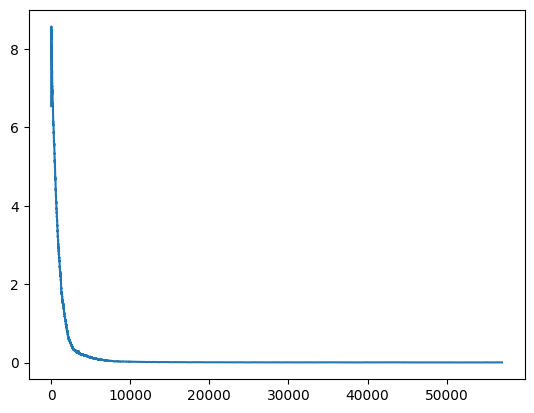

In [49]:
pd.Series(losses).ewm(100).mean().plot();

In [50]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [51]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['tü alijuna makatakalü sümaa teikalü']
['Miguel está contento con la criolla [que se quedó mi madre]']
['la cosecha está madura con mi madre']


In [52]:
!ls -alsh $MODEL_SAVE_PATH

total 2.4G
4.0K drwxrwxr-x 2 americasnlp americasnlp 4.0K Mar  8 19:40 .
4.0K drwxrwxr-x 4 americasnlp americasnlp 4.0K Mar  8 19:31 ..
 84K -rw-rw-r-- 1 americasnlp americasnlp  82K Mar  8 19:33 all_texts_file.csv
4.0K -rw-rw-r-- 1 americasnlp americasnlp  896 Mar  9 01:20 config.json
4.0K -rw-rw-r-- 1 americasnlp americasnlp  184 Mar  9 01:20 generation_config.json
2.3G -rw-rw-r-- 1 americasnlp americasnlp 2.3G Mar  9 01:20 pytorch_model.bin
4.7M -rw-rw-r-- 1 americasnlp americasnlp 4.7M Mar  9 01:20 sentencepiece.bpe.model
4.0K -rw-rw-r-- 1 americasnlp americasnlp 3.5K Mar  9 01:20 special_tokens_map.json
264K -rw-rw-r-- 1 americasnlp americasnlp 264K Mar  8 19:33 spm_16k.model
 36K -rw-rw-r-- 1 americasnlp americasnlp  34K Mar  8 19:33 spm_16k.vocab
4.7M -rw-rw-r-- 1 americasnlp americasnlp 4.7M Mar  8 19:34 spm_nllb_268k.model
4.0K -rw-rw-r-- 1 americasnlp americasnlp  570 Mar  9 01:20 tokenizer_config.json


<h1 id="7.-Using-the-model">7. Testing the model</h1>

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [54]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [55]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_SAVE_PATH).cuda(CUDA_CORE)
tokenizer = NllbTokenizer.from_pretrained(MODEL_SAVE_PATH)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [56]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [57]:
t = "las canciones de amor me gustan mucho"
print(translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL))

["anashaanasü ma'i pütchikanasü ma'i taya"]


In [58]:
translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['Kamalainsü tei']

In [59]:
t = "kuyakuyllawan takitam anchata kuyani"
print(translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL))

['Yo golpeo el muchacho de la muchacha']


In [60]:
translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['Yo compro los honoríficoes de la hermana.']

In [61]:
def batched_translate(texts, batch_size=8, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [62]:
# df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_TARGET_LABEL"], src_lang=LANGUAGE_TARGET_LABEL, tgt_lang=LANGUAGE_ORIGIN_LABEL)
# df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_ORIGIN_LABEL"], src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL)

In [63]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

In [64]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [65]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 41.75 51.7/39.9/38.4/38.4 (BP = 1.000 ratio = 1.079 hyp_len = 1471 ref_len = 1363)
chrF2++ = 52.67
BLEU = 31.02 49.4/32.7/27.2/25.2 (BP = 0.956 ratio = 0.957 hyp_len = 984 ref_len = 1028)
chrF2++ = 50.76


In [66]:
pd.options.display.max_colwidth = 100

In [67]:
df_test.sample(10, random_state=42)[[LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_translated', LANGUAGE_FILE_ORIGIN_LABEL + '_translated']]

,way,esp,way_translated,esp_translated
1024,Nüchon Kamiirü pia.,Tú eres hijo de Camilo.,Jüchonkai pia Kamiirü.,Tú eres el que va a morir ahora.
259,¿Kasa jaa Ꞌinraka a?,¿Qué hacen?,¿Kasa jaa Ꞌinraka?,¿Qué hacen?
889,A’yataashi taya eepu’ule ni’yataain chi alijunakai.,Yo trabajo donde solía trabajar el criollo.,A'yataashicheje taya jünaain a'yataain chi alijunakai.,Yo nunca había probado ningún criollo.
678,¿KasoꞋulajana waya?,¿Qué día es hoy?,¿Kaso'utsü mi'irakalü?,¿Cuándo nos vamos a comprar?
899,Nümataalakalaka chi nashikai yaa: Anakaja'a amülouitaale paala naya.,Entonces dijo su padre: Sería bueno si se perdieran.,Nümataalakalaka chi nashikai yaa: Anakaja'a amülouitaale.,Entonces su padre dijo: Ellos antes se perdieran.
477,"Jashü'üsü tü uujotkoo, taseeshaintain sünain müin shia.","Esta chicha está fermentada, así es que me gusta.","Jemetüsü ma'in uujotka tüü, jia'aya tü ma'in taya.","La chicha está sabrosa, me regalas un poquito para llevarle a mi mamá."
113,Eesü kaa'ula jee anneerü sulu ’u Wajiirü.,Hay chivos y ovejos en La Guajira.,Eesü kaa'ula jee anneerü sulu'u Wajiirü.,Hay chivos y ovejos en La Guajira.
1328,"A'lakajaainjatüyaa taya, akatsa'a nnojolu in siki","Yo iba a cocinar, pero no había leña.","A'lakajaainjatü taya, akaisa'a m asukajaanüin taya","Yo iba a cocinar, pero a mí no me olvidé."
1046,"Nümüleraain nü'liima , nü'rülü , ni'ichi oo'ulaka müsüya nuu'uipa'a .","Le palpaba barba y bigote, las pestañas, la nariz, la planta del pie.","Jatüipüinjatü yüttaa, kalapaasü, c. Eesü süpüla tü waraitaa, otta jokomain shia.",Para llegar aquí le contó a ella lo que le había sucedido donde el otro viejo.
1361,"Naa wayuu natajanairua eeshi süpula neitainjatüin tüü e'ikilepülekat, tüü süpulajanakat shianjat...",Los particulares podrán fundar establecimiento educativos. La ley establecerá las condiciones pa...,"Naa wayuu natajanairua eeshi süpula neitainjatüin tüü e'ikilepülekat, tüü süpulajanakat shianjat...",Los particulares podrán fundar establecimiento educativos. La ley establecerá las condiciones pa...
